In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt

def synth_x(f, Ns, fs=256, mu=0, sigma=0):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    sine = np.sin(t*2*np.pi*f)
    return sine + np.random.normal(mu, sigma, sine.shape)

def synth_X(f, Nc, Ns, Nt=1, fs=256, mu=0, sigma=0):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f
            x = synth_x(f_i, Ns, fs=fs, mu=mu, sigma=sigma)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

def clean_results(g,m):
    for key, prob in g.items():
        g[key] = abs(prob)
    return max(g, key=g.get), max(m, key=m.get)

def retrieve_scores(gcca_total_res, mset_total_res):
    gcca_scores = {}
    mset_scores = {}

    for freq, decoded in gcca_total_res.items():
        gcca_scores[freq] = 0
        for result in decoded:
            if result[0] == freq:
                gcca_scores[freq]+=1
                
    for freq, decoded in mset_total_res.items():
        mset_scores[freq] = 0
        for result in decoded:
            if result[0] == freq:
                mset_scores[freq]+=1
    
    return gcca_scores, mset_scores

def generate_pure_sine_train(freqs, fs, trials):
    data = []
    for f in freqs:
        data.append((synth_X(f,1,fs,trials).T).reshape(1,fs,trials))
    return np.array(data)

def generate_pure_sine_test(f, fs, numTests):
    data = []
    for i in range(numTests):
        data.append(synth_x(f, fs, fs=fs, mu=0, sigma=0).reshape(1,fs))
    return data

def generate_noisy_sine_train(freqs, fs, trials, std):
    data = []
    for f in freqs:
        data.append((synth_X(f,1,fs,trials,sigma=std).T).reshape(1,fs,trials))
    return np.array(data)

def generate_noisy_sine_test(f, fs, numTests, std):
    data = []
    for i in range(numTests):
        data.append(synth_x(f, fs, fs=fs, mu=0, sigma=std).reshape(1,fs))
    return data

In [ ]:
x = synth_x(1, 256, fs=256, mu=0, sigma=0)
for i in range(2,15):
    if i == 10:
        x+= 1*synth_x(10, 256, fs=256, mu=0, sigma=0)
    else:
        x+= synth_x(i, 256, fs=256, mu=0, sigma=0)
plt.plot(x)

In [10]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs=256
trials = 2

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

print(synth_X(7,1,256,trials).shape)
synth_7 = (synth_X(7,1,256,trials).T).reshape(1,fs,trials)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,trials).T).reshape(1,fs,trials)
synth_12 = (synth_X(12,1,256,trials).T).reshape(1,fs,trials)

train = np.array([synth_7, synth_10, synth_12])

print(train.shape)
gcca.fit(train)
mset_cca.fit(train)


gcca_res = gcca.classify(generate_pure_sine_test(7,256,10)[0])
mset_res = mset_cca.classify(generate_pure_sine_test(7,256,10)[0])

(2, 256)
(1, 256, 2)
(3, 1, 256, 2)


/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


In [4]:
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=mset_res.get))
print(mset_res)

7
{7: 1.991593098007596, 10: 1.0641419036142961e-32, 12: 3.2067519220714506e-33}
7
{7: 1.0, 10: 5.681576962401906e-17, 12: 1.4792430064454493e-19}


In [ ]:
gcca.fit(generate_noisy_sine_train([7,10,12],256,4,0))
gcca_res = gcca.classify(generate_noisy_sine_test(7,256,4,0)[0])

mset_cca.fit(generate_noisy_sine_train([7,10,12],256,4,10))
mset_res = mset_cca.classify(generate_noisy_sine_test(7,256,4,10)[0])

In [ ]:
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=mset_res.get))
print(mset_res)

In [ ]:
plt.plot(generate_noisy_sine_test(7,256,4,0)[0].flatten())

# PURE SINE TESTS AND PLOT

In [33]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs= 256
trials = 4
numTests = 10

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

train = generate_pure_sine_train(freqs, fs, trials)
print(train.shape)
gcca.fit(train)
mset_cca.fit(train)

gcca_total_res = {}
mset_total_res = {}

for f in freqs:
    gcca_arr = []
    mset_arr = []
    tests = generate_pure_sine_test(f, fs, numTests)
    for test in tests:
        gcca_res = gcca.classify(test)
        mset_res = mset_cca.classify(test)
        g, m = clean_results(gcca_res,mset_res)
        gcca_arr.append((g,gcca_res))
        mset_arr.append((m,mset_res))
    gcca_total_res[f] = gcca_arr
    mset_total_res[f] = mset_arr
    
print(retrieve_scores(gcca_total_res, mset_total_res))

(3, 1, 256, 4)
({7: 10, 10: 10, 12: 10}, {7: 10, 10: 10, 12: 10})


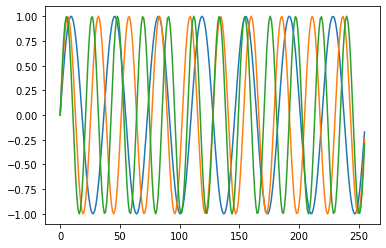

In [38]:
plt.plot()
fig
plt.plot(train[1,0,:,0])
plt.plot(train[2,0,:,0])

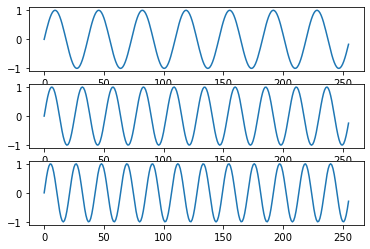

In [43]:
import matplotlib.pyplot as plt
import numpy as np

fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
ax1.plot(train[0,0,:,0])
ax2.plot(train[1,0,:,0])
ax3.plot(train[2,0,:,0])